In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from utils.svoboda_data_utils import *
import pandas as pd
from pynwb import NWBHDF5IO
import pickle
import torch
import glob
import scipy

import math
import seaborn as sns
from loader.data_loader_unbalanced_lump import load_session_data, update_area_ind_list_and_areaoi_ind

In [3]:
session_order = pickle.load(open('/work/hdd/bdye/jxia4/data/tables_and_infos/session_order.pkl', 'rb'))

eids = np.sort(session_order[:50])

path = '/work/hdd/bdye/jxia4/data/tables_and_infos/'

#load region_info_summary.pkl
with open(path + 'region_info_summary.pkl', 'rb') as f:
    [brain_region_list, session_by_region, session_by_region_n, junk] = pickle.load(f)

brain_region_list = np.append(brain_region_list, 'ALM') #add ALM to the list

areaoi = ['ALM', #according to is_ALM
        'Orbital area, lateral part', #lump layers
        'Orbital area, ventrolateral part', #lump layers
        'Pallidum', #include Pallidum, Globus pallidus, external segment
        'Striatum', #include Striatum, Caudoputamen
        'Primary somatosensory area, upper limb', #lump layers
        'Primary somatosensory area, nose', #lump layers
        'Primary somatosensory area, mouth', #lump layers
        'VAL-VM', #include Ventral anterior-lateral complex of the thalamus, Ventral medial nucleus of the thalamus
        'Mediodorsal nucleus of thalamus',
        'Lateral posterior nucleus of the thalamus', 
        'Posterior complex of the thalamus',
        'Midbrain reticular nucleus',
        'Superior colliculus, motor related', #lump layers
        'Substantia nigra, reticular part',
        'Medulla']

In [4]:
trial_type_dict = {}
opto_type_ind_list = []

trial_type_include = []

i = 0
for name1 in ['left', 'right']:
    for name2 in ['hit', 'miss', 'ignore']:
        for name3 in ['', 'opto_early_4_', 'opto_late_4_', 'opto_early_5_', 'opto_late_5_', 'opto_early_6_', 'opto_late_6_']:
            trial_type_dict[name3 + name2 + '_' + name1] = i
            
            if 'opto' in name3:
                opto_type_ind_list.append(i)
            
            elif name2=='hit':
                trial_type_include.append(i)

            i += 1

In [5]:
trial_type_include

[0, 21]

In [6]:
def calculate_participation_ratio(y):
    '''
    y: N x T x K

    return pr, a constant
    '''
    y = y.reshape(y.shape[0], -1, order='F') # N x T*n_trials

    y = y - np.mean(y, axis=1)[:, None]
    cov = np.dot(y, y.T)
    eigvals = np.linalg.eigvalsh(cov)

    pr= np.sum(eigvals)**2 / np.sum(eigvals**2)
    return pr

In [7]:
def smooth_data(y, window_size=100, sigma=5):
    '''
    y: N x T x K
    return: y_smooth: N x T x K
    '''

    y_flat = y.reshape((y.shape[0], -1), order='F')

    # Create the Gaussian kernel
    kernel = scipy.signal.windows.gaussian(window_size, sigma)

    y_smooth_flat = np.zeros_like(y_flat)  
    for i in range(y.shape[0]):
        y_smooth_flat[i] = np.convolve(y_flat[i], kernel, mode='same')
    y_smooth = y_smooth_flat.reshape(y.shape, order='F')

    return y_smooth

In [8]:
pr_dict = {}
n_dict = {}

pr_list = {}
n_neurons_list = {}

for session_ind in eids:
    pr_dict[session_ind] = {}
    n_dict[session_ind] = {}
    
    spike_data_unbalanced, behavior_unbalanced, area_ind_list, is_left, is_ALM, trial_type_unbalanced = load_session_data(session_ind, trial_type_dict)

    areaoi_ind, area_ind_list = update_area_ind_list_and_areaoi_ind(area_ind_list, areaoi, brain_region_list, is_ALM)

    flag_include_trials = np.zeros(len(trial_type_unbalanced), dtype=bool)
    for ind in trial_type_include:
        flag_include_trials[trial_type_unbalanced == ind] = True

    spike_data_unbalanced = spike_data_unbalanced[:,:,flag_include_trials==1]

    for area_ind in areaoi_ind:
        if area_ind not in area_ind_list:
            continue
        area_name = brain_region_list[area_ind]
        if area_name not in pr_list.keys():
            pr_list[area_name] = []
            n_neurons_list[area_name] = []

        # spike_data_tmp = spike_data_unbalanced[(area_ind_list==area_ind) & (is_left==0), :, :]
        # if spike_data_tmp.shape[0] == 0:
        #     continue

        spike_data_tmp = spike_data_unbalanced[area_ind_list==area_ind, :, :]

        smoothed_spike_data_tmp = smooth_data(spike_data_tmp)

        n = spike_data_tmp.shape[0]
        pr = calculate_participation_ratio(smoothed_spike_data_tmp)

        pr_dict[session_ind][area_ind] = pr
        n_dict[session_ind][area_ind] = n

        pr_list[area_name].append(pr)
        n_neurons_list[area_name].append(n)


In [9]:
def plot_scatter(n_neurons_list, pr_list, y_label, error_bar_list=None, areaoi_ind=areaoi_ind):

    pr_max_dict = {}

    n_subplot = len(pr_list.keys())
    fig, ax = plt.subplots(3, math.ceil(n_subplot/3), figsize=(n_subplot+2, 7))
    i = 0
    for area_ind in areaoi_ind:
        area_name = brain_region_list[area_ind]
        if area_name not in pr_list.keys():
            continue
        row_i = i // math.ceil(n_subplot/3)
        col_i = i % math.ceil(n_subplot/3)
        if error_bar_list is None:
            ax[row_i, col_i].scatter(n_neurons_list[area_name], pr_list[area_name], label=area_name)
        else:
            ax[row_i, col_i].errorbar(n_neurons_list[area_name], pr_list[area_name], yerr=error_bar_list[area_name], fmt = 'o')
        
        if len(area_name) > 25:
            title_tmp = area_name[:25] + '...'
        else:
            title_tmp = area_name
        title_tmp = title_tmp + '\n' + f'{len(pr_list[area_name])} sessions'
        ax[row_i, col_i].set_title(title_tmp)

        ax[row_i, col_i].set_xlabel('# of neurons')
        ax[row_i, col_i].set_ylabel(y_label)

        n_max = np.max(n_neurons_list[area_name])
        pr_max = np.max(pr_list[area_name])
        max_tmp = np.max([n_max, pr_max]) + 5

        ylim = [0, pr_max+5]
        xlim = [0, max_tmp]
        
        ax[row_i, col_i].set_xlim(xlim)
        ax[row_i, col_i].set_ylim(ylim)
        i += 1

        pr_max_dict[area_ind] = np.ceil(pr_max)
    
    if i <= 3*math.ceil(n_subplot/3):
        for j in range(i, 3*math.ceil(n_subplot/3)):
            row_i = j // math.ceil(n_subplot/3)
            col_i = j % math.ceil(n_subplot/3)
            ax[row_i, col_i].axis('off')

    plt.tight_layout()
    plt.show()

    return pr_max_dict

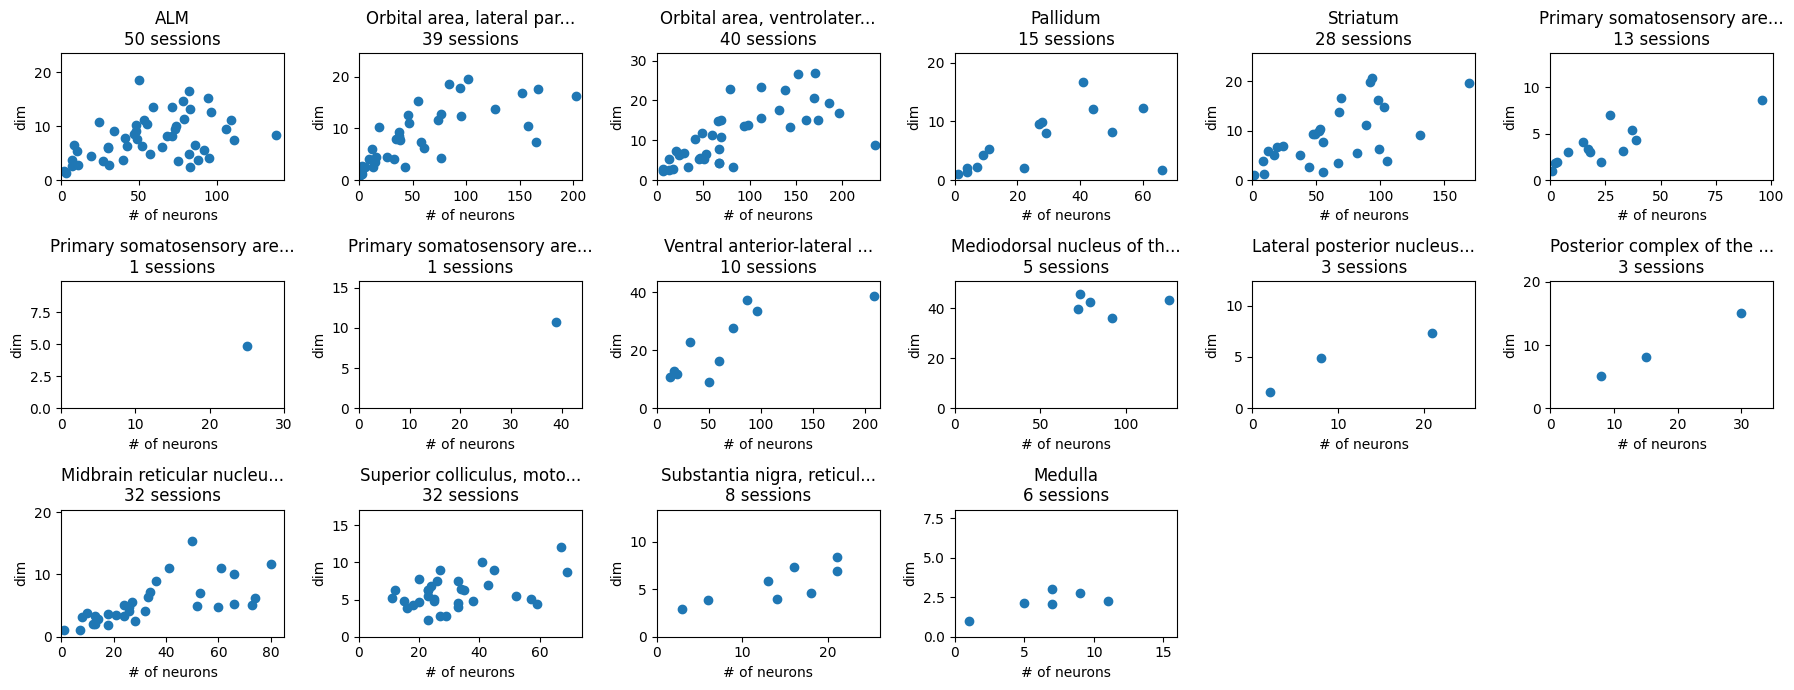

In [10]:
pr_max_dict = plot_scatter(n_neurons_list, pr_list, 'dim')

In [20]:
pr_max_dict

{np.int64(293): np.float64(19.0),
 np.int64(139): np.float64(21.0),
 np.int64(146): np.float64(27.0),
 np.int64(150): np.float64(13.0),
 np.int64(248): np.float64(21.0),
 np.int64(213): np.float64(12.0),
 np.int64(200): np.float64(14.0),
 np.int64(195): np.float64(11.0),
 np.int64(279): np.float64(39.0),
 np.int64(119): np.float64(47.0),
 np.int64(100): np.float64(47.0),
 np.int64(172): np.float64(47.0),
 np.int64(124): np.float64(12.0),
 np.int64(258): np.float64(11.0),
 np.int64(256): np.float64(9.0),
 np.int64(120): np.float64(6.0)}

In [21]:
#save pr_max_dict
with open(path + 'pr_max_dict.pkl', 'wb') as f:
    pickle.dump(pr_max_dict, f)

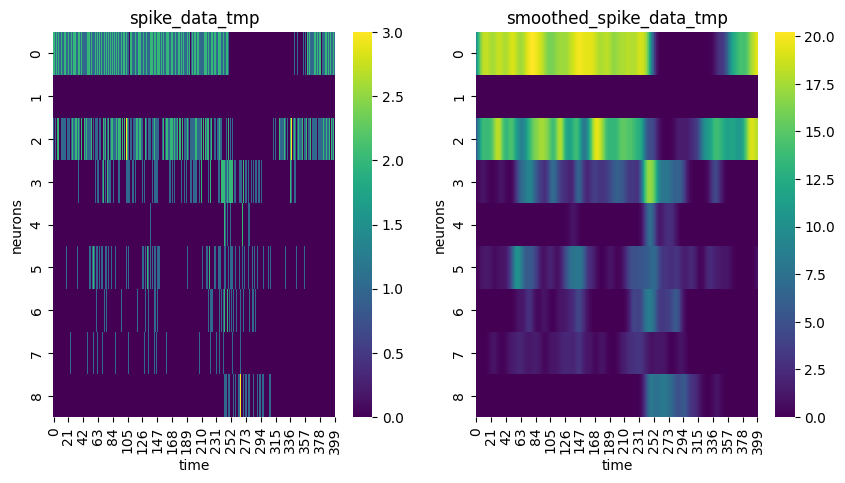

In [26]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(spike_data_tmp[:,:,0], cmap='viridis')
plt.title('spike_data_tmp')
plt.xlabel('time')
plt.ylabel('neurons')
plt.subplot(1, 2, 2)
sns.heatmap(smoothed_spike_data_tmp[:,:,0], cmap='viridis')
plt.title('smoothed_spike_data_tmp')
plt.xlabel('time')
plt.ylabel('neurons')
plt.show()
